In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math

In [2]:
import os
import sys
new_path = "d:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/"
sys.path.append(new_path)

from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
#from ada_boost_standard_v2 import AdaBoostStandardClassifier_v2;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;


In [3]:
def compute_metrics(y_test, y_pred):
    print('Accuracy: {:.5f}'.format(accuracy_score(y_test, y_pred)))
    print('F-score: {:.5f}'.format(f1_score(y_test, y_pred)))
    print('Precision: {:.5f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.5f}'.format(recall_score(y_test, y_pred)))
    print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))
    print('MCC: {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))

def compute_confusion_matrix(y_test, y_pred, labels=[1, -1]):
    compute_metrics(y_test, y_pred)
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=labels),
        columns=['a(x) = '+str(labels[0]), 'a(x) = '+str(labels[1])],
        index=['y = '+str(labels[0]), 'y = '+str(labels[1])],
    ).T

In [4]:
def draw_data_by_coord01(x_data, y_data, v_normal):
    plt.scatter(x_data[:, 0], x_data[:, 1], marker="o", c=y_data, s=10, edgecolor="k")
    y2_coord = -2*v_normal[0]/(v_normal[1] + 1e-10)
    plt.plot([-2,2], [-y2_coord, y2_coord], color='r')
    plt.show()


In [5]:
#Linear
def get_predicts_linear_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostLinear_v1()
    result, message, _ = clf.fit(X_train, y_train, allow_nonseparable=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    margin = clf.get_margin()
    return y_pred, margin, separated, clf
    
#Ada-boost sklearn
def get_predict_sklearn(X_train, X_test, y_train, y_test):
    clf = AdaBoostClassifier(n_estimators=1000, random_state=0)
    clf.fit(X_train, y_train)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    return y_pred, separated, clf

#Ada-boost decision-stump
def get_predict_stump_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostStandardClassifier_v1(n_estimators=150)
    clf.fit(X_train, y_train, trace=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf


In [6]:
REPEAT_COUNT = 3
TEST_SIZE = 0.33

### Simple separable dataset, 6 rows 4 features

In [7]:
X_train = np.array([[0.6476239, -0.81753611, -1.61389785, -0.21274028],
       [-2.3748206 ,  0.82768797, -0.38732682, -0.30230275],
       [ 1.51783379,  1.22140561, -0.51080514, -1.18063218],
       [-0.98740462,  0.99958558, -1.70627019,  1.9507754],
       [-1.43411205,  1.50037656, -1.04855297, -1.42001794],
       [ 0.29484027, -0.79249401, -1.25279536,  0.77749036]])

y_train = np.array([1, -1, -1, 1, 1, -1])

clf = AdaBoostStandardClassifier_v1(n_estimators=100)
result, history = clf.fit(X_train, y_train, trace=True)
y_pred = clf.predict(X_train)
assert (y_train==y_pred).all(), 'Wrong answer'
print("Ada boost margin:", clf.get_margin_l1(X_train))
clf = AdaBoostLinear_v1()
result, message, log = clf.fit(X_train, y_train, trace=False)
y_pred = clf.predict(X_train)
assert (y_train==y_pred).all(), 'Wrong answer'
print("Linear classifier margin: ", clf.get_margin())

Ada boost margin: 0.4431265830030106
Linear classifier margin:  0.4545454546788366


### Separable normaly distributed data, 2 features, train set - 1333, test set - 667

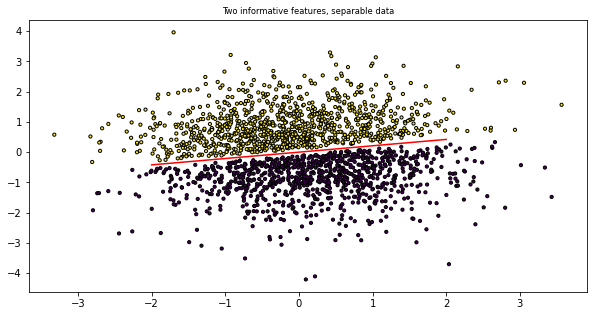

In [32]:
plt.figure(figsize=(10, 5))
plt.title("Two informative features, separable data", fontsize="small")
x_2000, y_2000, v_normal = make_classification_normal(2, 2000, rho=0.1)
draw_data_by_coord01(x_2000, y_2000, v_normal)

##### Linear algorithm

In [33]:
start = time.time()
cnt = 0
margins = []
while cnt < REPEAT_COUNT:
    X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(x_2000, y_2000, test_size=TEST_SIZE) #, random_state=42)
    clf2000_linear = AdaBoostLinear_v1()
    _, _, _ = clf2000_linear.fit(X_train2000, y_train2000, allow_nonseparable=True)
    separated = accuracy_score(y_train2000, clf2000_linear.predict(X_train2000))
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins.append(clf2000_linear.get_margin())
    cnt += 1

end = time.time()
margin_linear = np.average(margins)
print("Elapsed time: {}".format(end - start))
print("Averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_linear))

Elapsed time: 43.031999349594116
Averag margin in 3 experiments: 0.16190476192382985


In [34]:
X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(x_2000, y_2000, test_size=TEST_SIZE) #, random_state=42)
clf2000_linear = AdaBoostLinear_v1()
_, _, _ = clf2000_linear.fit(X_train2000, y_train2000, allow_nonseparable=True)
y_test2000_forecast = clf2000_linear.predict(X_test2000)
compute_confusion_matrix(y_test2000, y_test2000_forecast, labels=[-1, 1])

Accuracy: 1.00000
F-score: 1.00000
Precision: 1.00000
Recall: 1.00000
Accuracy (balanced): 1.00000
MCC: 1.00000


,y = -1,y = 1
a(x) = -1,346,0
a(x) = 1,0,314


##### Ada boost with decision stump

In [35]:
start = time.time()
cnt = 0
margins = []
while cnt < REPEAT_COUNT:
    X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(x_2000, y_2000, test_size=TEST_SIZE) #, random_state=42)
    clf2000v1 = AdaBoostStandardClassifier_v1(n_estimators=50)
    result, history = clf2000v1.fit(X_train2000, y_train2000, trace=True)
    separated = accuracy_score(y_train2000, clf2000v1.predict(X_train2000))
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins.append(clf2000v1.get_margin_l1(X_train2000))
    cnt += 1
    
end = time.time()
margin_v1 = np.average(margins)
print("Elapsed time: {}".format(end - start))
print("Averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_v1))

Elapsed time: 774.5368530750275
Averag margin in 3 experiments: 0.10162690005586394


In [36]:
X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(x_2000, y_2000, test_size=TEST_SIZE) #, random_state=42)
clf2000v1 = AdaBoostStandardClassifier_v1()
_, _ = clf2000v1.fit(X_train2000, y_train2000)
y_pred2000v1 = clf2000v1.predict(X_test2000)
compute_confusion_matrix(y_test2000, y_pred2000v1, labels=[1, -1])

Accuracy: 0.99697
F-score: 0.99699
Precision: 1.00000
Recall: 0.99399
Accuracy (balanced): 0.99700
MCC: 0.99396


,y = 1,y = -1
a(x) = 1,331,0
a(x) = -1,2,327


##### Sklearn algorithm

In [37]:
clf2000std = AdaBoostClassifier(n_estimators=100, random_state=0)
clf2000std.fit(X_train2000, y_train2000)
y_pred2000std = clf2000std.predict(X_test2000)
print("Separated: {}".format\
      (accuracy_score(y_train2000, clf2000_linear.predict(X_train2000)) >= 1))
compute_confusion_matrix(y_test2000, y_pred2000std, labels=[-1, 1])

Separated: True
Accuracy: 0.99545
F-score: 0.99548
Precision: 1.00000
Recall: 0.99099
Accuracy (balanced): 0.99550
MCC: 0.99095


,y = -1,y = 1
a(x) = -1,327,3
a(x) = 1,0,330


##### Data set 2 features, 1333 rows in train, average margins for different classifiers

In [38]:
print("Linear algorithm classifier, averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_linear))
print("Ada boost classifier, averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_v1))

Linear algorithm classifier, averag margin in 3 experiments: 0.16190476192382985
Ada boost classifier, averag margin in 3 experiments: 0.10162690005586394


### Separable data, 10 clusters, 50 features, 20 informative, train set - 667, test set - 333

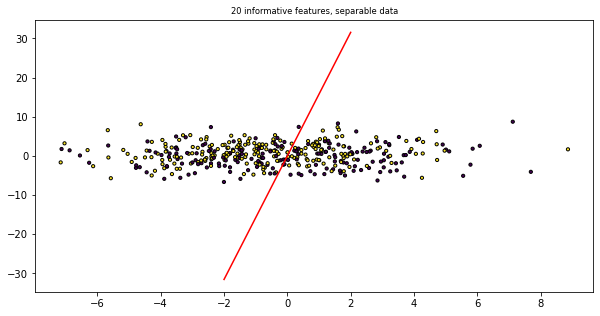

In [39]:
from sklearn.datasets import make_classification

x_1000, _ = make_classification(n_samples=400, n_features=50,n_informative=20
                                , n_redundant=20, random_state=0, n_clusters_per_class=5, shuffle=False)

plt.figure(figsize=(10, 5))
plt.title("20 informative features, separable data", fontsize="small")
x_1000, y_1000, v_normal = make_separable_labels(x_1000, rho=0.1)
draw_data_by_coord01(x_1000, y_1000, v_normal)


##### Linear algorithm

In [40]:
start = time.time()
cnt = 0
margins = []
accuracies = []
while cnt < REPEAT_COUNT:
    X_train1000, X_test1000, y_train1000, y_test1000 = train_test_split(x_1000, y_1000, test_size=TEST_SIZE)
    clf2_linear = AdaBoostLinear_v1()
    _, _, _ = clf2_linear.fit(X_train1000, y_train1000, allow_nonseparable=True)
    separated = accuracy_score(y_train1000, clf2_linear.predict(X_train1000))
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins.append(clf2_linear.get_margin())
    accuracies.append(accuracy_score(y_test1000, clf2_linear.predict(X_test1000)))
    cnt += 1

end = time.time()
margin_linear = np.average(margins)
accuracy_linear = np.average(accuracies)
print("Elapsed time: {}".format(end - start))
print("Average margin in {} experiments: {}".format(REPEAT_COUNT, margin_linear))
print("Average accuracy in {} experiments: {}".format(REPEAT_COUNT, accuracy_linear))

Elapsed time: 41.39903545379639
Average margin in 3 experiments: 0.12760278654198767
Average accuracy in 3 experiments: 0.8813131313131314


In [41]:
X_train1000, X_test1000, y_train1000, y_test1000 = train_test_split(x_1000, y_1000, test_size=TEST_SIZE)
clf2_linear = AdaBoostLinear_v1()
_, _, _ = clf2_linear.fit(X_train1000, y_train1000, allow_nonseparable=True)
compute_confusion_matrix(y_test1000, clf2_linear.predict(X_test1000), labels=[-1, 1])

Accuracy: 0.84848
F-score: 0.84848
Precision: 0.83582
Recall: 0.86154
Accuracy (balanced): 0.84868
MCC: 0.69736


,y = -1,y = 1
a(x) = -1,56,9
a(x) = 1,11,56


##### Ada boost with decision stump

In [42]:
start = time.time()
cnt = 0
margins = []
accuracies = []
while cnt < REPEAT_COUNT:
    X_train1000, X_test1000, y_train1000, y_test1000 = train_test_split(x_1000, y_1000, test_size=TEST_SIZE)
    clf2v2 = AdaBoostStandardClassifier_v1(n_estimators=50)
    result, history = clf2v2.fit(X_train1000, y_train1000, trace=True)
    separated = accuracy_score(y_train1000, clf2v2.predict(X_train1000))
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins.append(clf2v2.get_margin_l1(X_train1000))
    accuracies.append(accuracy_score(y_test1000, clf2v2.predict(X_test1000)))
    cnt += 1

end = time.time()
margin_v1 = np.average(margins)
accuracy_v1 = np.average(accuracies)
print("Elapsed time: {}".format(end - start))
print("Average margin in {} experiments: {}".format(REPEAT_COUNT, margin_v1))
print("Average accuracy in {} experiments: {}".format(REPEAT_COUNT, accuracy_v1))

Elapsed time: 772.1760094165802
Average margin in 3 experiments: 0.03376176424971137
Average accuracy in 3 experiments: 0.8737373737373737


In [43]:
X_train1000, X_test1000, y_train1000, y_test1000 = train_test_split(x_1000, y_1000, test_size=TEST_SIZE) #, random_state=42)
clf2v2 = AdaBoostStandardClassifier_v1(n_estimators=50)
result, history = clf2v2.fit(X_train1000, y_train1000, trace=True)
compute_confusion_matrix(y_test1000, clf2v2.predict(X_test1000), labels=[-1, 1])

Accuracy: 0.88636
F-score: 0.89209
Precision: 0.87324
Recall: 0.91176
Accuracy (balanced): 0.88557
MCC: 0.77301


,y = -1,y = 1
a(x) = -1,55,6
a(x) = 1,9,62


##### Sklearn algorithm

In [44]:
clf2std = AdaBoostClassifier(n_estimators=150, random_state=0)
clf2std.fit(X_train1000, y_train1000)
y_pred1000std = clf2std.predict(X_test1000)
print("Separated: {}".format\
      (accuracy_score(y_train1000, clf2std.predict(X_train1000)) >= 1))
compute_confusion_matrix(y_test1000, y_pred1000std, labels=[-1, 1])

Separated: True
Accuracy: 0.88636
F-score: 0.88889
Precision: 0.89552
Recall: 0.88235
Accuracy (balanced): 0.88649
MCC: 0.77271


,y = -1,y = 1
a(x) = -1,57,8
a(x) = 1,7,60


##### Data set 10 clusters, 50 features, 20 informative features, 667 rows in train set, 333 rows in test set

In [45]:
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, margin_linear, accuracy_linear))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, margin_v1, accuracy_v1))

Linear classifier, 3 experiments. Avg. margin on train set: 0.1276027865, avg. accuracy on test set: 0.8813131313
Ada boost classifier, 3 experiments. Avg. margin on train set: 0.0337617642, avg. accuracy on test set: 0.8737373737


### Breast cancer data set

In [46]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/breast-cancer/'

df = pd.read_csv(path+'breast-cancer-wisconsin.data', header=None)
df.fillna(0, inplace=True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [47]:
raw = df.to_numpy(copy=True)
x_data = raw[:, 1:10]
y_data = raw[:, 10].astype(int) - 3

print("Breast cancer: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

Breast cancer: 699 rows, 9 features


#### Check if dataset is separable

In [48]:
from sklearn import svm

clf = svm.SVC(C = 10**5)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)


1.0

#### Linear ada-boost

In [49]:
start = time.time()
cnt = 0
margins = []
accuracies = []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    y_pred, margin, separated, clf1 = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    #result, history = clf2v2.fit(X_train1000, y_train1000, trace=True)
    #separated = accuracy_score(y_train1000, clf2v2.predict(X_train1000))
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins.append(margin)
    accuracies.append(accuracy_score(y_test, y_pred))
    cnt += 1

end = time.time()
margin_linear = np.average(margins)
accuracy_linear = np.average(accuracies)
print("Elapsed time: {}".format(end - start))
print("Averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_linear))
print("Average accuracy in {} experiments: {}".format(REPEAT_COUNT, accuracy_linear))

Elapsed time: 22.279001235961914
Averag margin in 3 experiments: 0.04091054979643329
Average accuracy in 3 experiments: 0.9509379509379509


In [50]:
y_pred, margin, separated, clf1 = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

Separated: 1.0, margin: 0.0371409691933884
Accuracy: 0.96970
F-score: 0.95758
Precision: 0.96341
Recall: 0.95181
Accuracy (balanced): 0.96577
MCC: 0.93405


,y = -1,y = 1
a(x) = -1,145,4
a(x) = 1,3,79


#### Decision-stump ada-boost

In [51]:
start = time.time()
cnt = 0
margins = []
accuracies = []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    y_pred, margin, separated, clf2 = get_predict_stump_v1(X_train, X_test, y_train, y_test)
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins.append(margin)
    accuracies.append(accuracy_score(y_test, y_pred))
    cnt += 1

end = time.time()
margin_v1 = np.average(margins)
accuracy_v1 = np.average(accuracies)
print("Elapsed time: {}".format(end - start))
print("Averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_v1))
print("Average accuracy in {} experiments: {}".format(REPEAT_COUNT, accuracy_v1))

Failed to separate, accuracy = 0.9893162393162394
Failed to separate, accuracy = 0.9957264957264957
Failed to separate, accuracy = 0.9957264957264957
Failed to separate, accuracy = 0.9978632478632479
Failed to separate, accuracy = 0.9893162393162394
Failed to separate, accuracy = 0.9743589743589743
Failed to separate, accuracy = 0.9978632478632479
Failed to separate, accuracy = 0.9935897435897436
Failed to separate, accuracy = 0.9978632478632479
Failed to separate, accuracy = 0.9914529914529915
Failed to separate, accuracy = 0.9850427350427351
Failed to separate, accuracy = 0.9978632478632479
Failed to separate, accuracy = 0.9957264957264957
Failed to separate, accuracy = 0.9935897435897436
Failed to separate, accuracy = 0.9914529914529915
Failed to separate, accuracy = 0.9935897435897436
Failed to separate, accuracy = 0.9978632478632479
Failed to separate, accuracy = 0.9871794871794872
Failed to separate, accuracy = 0.9743589743589743
Failed to separate, accuracy = 0.9914529914529915


In [52]:
y_pred, margin, separated, clf2 = get_predict_stump_v1(X_train, X_test, y_train, y_test)
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

Separated: 1.0, margin: 0.018868277464003068
Accuracy: 0.93506
F-score: 0.90683
Precision: 0.89024
Recall: 0.92405
Accuracy (balanced): 0.93242
MCC: 0.85738


,y = -1,y = 1
a(x) = -1,143,6
a(x) = 1,9,73


#### Sklearn ada-boost

In [53]:
y_pred, separated, clf3 = get_predict_sklearn(X_train, X_test, y_train, y_test)
print("Separated: {}".format(separated))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

Separated: 1.0
Accuracy: 0.93506
F-score: 0.90798
Precision: 0.88095
Recall: 0.93671
Accuracy (balanced): 0.93546
MCC: 0.85885


,y = -1,y = 1
a(x) = -1,142,5
a(x) = 1,10,74


##### Breast cancer data set,  9 features, 468 rows in train set, 231 rows in test set. 

In [54]:
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, margin_linear, accuracy_linear))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, margin_v1, accuracy_v1))

Linear classifier, 3 experiments. Avg. margin on train set: 0.0409105498, avg. accuracy on test set: 0.9509379509
Ada boost classifier, 3 experiments. Avg. margin on train set: 0.0131425416, avg. accuracy on test set: 0.9480519481


### Ionosphere

In [55]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/ionosphere/'

df = pd.read_csv(path+'ionosphere.data', header=None)
df['decoded'] = df[34].apply(lambda x: -1 if x == 'b' else 1)
#df.fillna(0, inplace=True)
df.head(5)


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,decoded
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b,-1
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b,-1
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g,1


In [56]:
raw = df.copy(True)
y_data_df = raw['decoded']
x_data_df = raw.drop([34, 'decoded'], axis = 1)
y_data = y_data_df.to_numpy(copy=True)
x_data = x_data_df.to_numpy(copy=True)
print("Ionosphere: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

Ionosphere: 351 rows, 34 features


#### Check if dataset is separable

In [57]:
from sklearn import svm

clf = svm.SVC(C=10**5)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)

1.0

#### Linear ada-boost

In [58]:
start = time.time()
cnt = 0
margins = []
accuracies = []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    y_pred, margin, separated, clf1 = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins.append(margin)
    accuracies.append(accuracy_score(y_test, y_pred))
    cnt += 1

end = time.time()
margin_linear = np.average(margins)
accuracy_linear = np.average(accuracies)
print("Elapsed time: {}".format(end - start))
print("Averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_linear))
print("Average accuracy in {} experiments: {}".format(REPEAT_COUNT, accuracy_linear))

Elapsed time: 21.598001956939697
Averag margin in 3 experiments: 0.12473927314283613
Average accuracy in 3 experiments: 0.8591954022988505


In [59]:
y_pred, margin, separated, clf1 = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

Separated: 1.0, margin: 0.12742667243193728
Accuracy: 0.88793
F-score: 0.91391
Precision: 0.88462
Recall: 0.94521
Accuracy (balanced): 0.86795
MCC: 0.75732


,y = -1,y = 1
a(x) = -1,34,4
a(x) = 1,9,69


#### Decision-stump ada-boost

In [60]:
start = time.time()
cnt = 0
margins = []
accuracies = []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    y_pred, margin, separated, clf2 = get_predict_stump_v1(X_train, X_test, y_train, y_test)
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins.append(margin)
    accuracies.append(accuracy_score(y_test, y_pred))
    cnt += 1

end = time.time()
margin_v1 = np.average(margins)
accuracy_v1 = np.average(accuracies)
print("Elapsed time: {}".format(end - start))
print("Averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_v1))
print("Average accuracy in {} experiments: {}".format(REPEAT_COUNT, accuracy_v1))

Elapsed time: 1236.6499009132385
Averag margin in 3 experiments: 0.07024567261870773
Average accuracy in 3 experiments: 0.9224137931034483


In [61]:
y_pred, margin, separated, clf2 = get_predict_stump_v1(X_train, X_test, y_train, y_test)
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

Separated: 1.0, margin: 0.07568617963822842
Accuracy: 0.93103
F-score: 0.94521
Precision: 0.90789
Recall: 0.98571
Accuracy (balanced): 0.91677
MCC: 0.85786


,y = -1,y = 1
a(x) = -1,39,1
a(x) = 1,7,69


#### Sklearn ada-boost

In [62]:
y_pred, separated, clf3 = get_predict_sklearn(X_train, X_test, y_train, y_test)
print("Separated: {}".format(separated))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

Separated: 1.0
Accuracy: 0.94828
F-score: 0.95833
Precision: 0.93243
Recall: 0.98571
Accuracy (balanced): 0.93851
MCC: 0.89268


,y = -1,y = 1
a(x) = -1,41,1
a(x) = 1,5,69


##### Ionosphere data set, 34 features, 234 rows in train set, 117 rows in test set.

In [63]:
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, margin_linear, accuracy_linear))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, margin_v1, accuracy_v1))

Linear classifier, 3 experiments. Avg. margin on train set: 0.1247392731, avg. accuracy on test set: 0.8591954023
Ada boost classifier, 3 experiments. Avg. margin on train set: 0.0702456726, avg. accuracy on test set: 0.9224137931


### Diabet

In [64]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/diabet/'

df = pd.read_csv(path+'diabetes.data', header=None)
df['decoded'] = df[8].apply(lambda x: -1 if x == 'tested_negative' else 1)
df.head(5)

,0,1,2,3,4,5,6,7,8,decoded
0,6,148,72,35,0,33.6,0.627,50,tested_positive,1
1,1,85,66,29,0,26.6,0.351,31,tested_negative,-1
2,8,183,64,0,0,23.3,0.672,32,tested_positive,1
3,1,89,66,23,94,28.1,0.167,21,tested_negative,-1
4,0,137,40,35,168,43.1,2.288,33,tested_positive,1


In [65]:
raw = df.copy(True)
y_data_df = raw['decoded']
x_data_df = raw.drop([8, 'decoded'], axis = 1)
y_data = y_data_df.to_numpy(copy=True)
x_data = x_data_df.to_numpy(copy=True)

print("Diabet: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

Diabet: 768 rows, 8 features


#### Check if dataset is separable

In [66]:
from sklearn import svm

clf = svm.SVC(C=10**8)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)

0.8528645833333334

In [67]:
clf = AdaBoostLinear_v1()
result, message, _ = clf.fit(x_data, y_data, allow_nonseparable=True)
separated = accuracy_score(y_data, clf.predict(x_data))
print("Separated: {}, margin: {}".format(separated, clf.get_margin()))

Separated: 1.0, margin: 0.0070401921891259074


#### Linear ada-boost

In [68]:
start = time.time()
cnt = 0
margins = []
accuracies = []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    y_pred, margin, separated, clf1 = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        continue
    margins.append(margin)
    accuracies.append(accuracy_score(y_test, y_pred))
    cnt += 1

end = time.time()
margin_linear = np.average(margins)
accuracy_linear = np.average(accuracies)
print("Elapsed time: {}".format(end - start))
print("Averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_linear))
print("Average accuracy in {} experiments: {}".format(REPEAT_COUNT, accuracy_linear))

Elapsed time: 27.530963897705078
Averag margin in 3 experiments: 0.011168153749760315
Average accuracy in 3 experiments: 0.6889763779527559


In [69]:
y_pred, margin, separated, clf1 = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

Separated: 1.0, margin: 0.010775627837338621
Accuracy: 0.70079
F-score: 0.60000
Precision: 0.65517
Recall: 0.55340
Accuracy (balanced): 0.67736
MCC: 0.36701


,y = -1,y = 1
a(x) = -1,121,46
a(x) = 1,30,57


#### Decision-stump ada-boost

In [70]:
start = time.time()
cnt = 0
margins = []
accuracies = []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    y_pred, margin, separated, clf2 = get_predict_stump_v1(X_train, X_test, y_train, y_test)
    if separated < 1:
        print("Failed to separate, accuracy = {}".format(separated))
        #continue
    margins.append(margin)
    accuracies.append(accuracy_score(y_test, y_pred))
    cnt += 1

end = time.time()
margin_v1 = np.average(margins)
accuracy_v1 = np.average(accuracies)
print("Elapsed time: {}".format(end - start))
print("Averag margin in {} experiments: {}".format(REPEAT_COUNT, margin_v1))
print("Average accuracy in {} experiments: {}".format(REPEAT_COUNT, accuracy_v1))

Failed to separate, accuracy = 0.8521400778210116
Failed to separate, accuracy = 0.8735408560311284
Failed to separate, accuracy = 0.867704280155642
Elapsed time: 1406.8941617012024
Averag margin in 3 experiments: 0.0001472307610277254
Average accuracy in 3 experiments: 0.7099737532808398


In [71]:
y_pred, margin, separated, clf2 = get_predict_stump_v1(X_train, X_test, y_train, y_test)
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

Separated: 0.867704280155642, margin: 0.00012385878408276488
Accuracy: 0.73228
F-score: 0.63830
Precision: 0.65934
Recall: 0.61856
Accuracy (balanced): 0.71055
MCC: 0.42669


,y = -1,y = 1
a(x) = -1,126,37
a(x) = 1,31,60


#### Sklearn ada-boost

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
y_pred, separated, clf3 = get_predict_sklearn(X_train, X_test, y_train, y_test)
print("Separated: {}".format(separated))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

Separated: 0.9941634241245136
Accuracy: 0.72835
F-score: 0.61017
Precision: 0.63529
Recall: 0.58696
Accuracy (balanced): 0.69780
MCC: 0.40295


,y = -1,y = 1
a(x) = -1,131,38
a(x) = 1,31,54


##### Diabet data set, 8 features, 514 rows in train set, 254 rows in test set.

In [73]:
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, margin_linear, accuracy_linear))
print("Ada boost classifier,{} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, margin_v1, accuracy_v1))

Linear classifier, 3 experiments. Avg. margin on train set: 0.0111681537, avg. accuracy on test set: 0.6889763780
Ada boost classifier,3 experiments. Avg. margin on train set: 0.0001472308, avg. accuracy on test set: 0.7099737533
